In [48]:
import os
import numpyro

import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import numpyro.distributions as dist
import pandas as pd
import seaborn as sns

from jax import random
from jaxlib.xla_extension import ArrayImpl
from numpyro.infer import MCMC, NUTS, Predictive


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=0)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
root_path = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/"
data_path = os.path.join(root_path, "WaffleDivorce.csv")

raw_df = pd.read_csv(data_path, sep=";")

raw_df.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [64]:
columns_to_select = ["MedianAgeMarriage", "Marriage", "Divorce"]

df = raw_df.copy().filter(items=columns_to_select, axis=1)
df.columns = ["age_raw", "married_raw", "divorced_raw"]

df.head()


,age_raw,married_raw,divorced_raw
0,25.3,20.2,12.7
1,25.2,26.0,12.5
2,25.8,20.3,10.8
3,24.3,26.4,13.5
4,26.8,19.1,8.0


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   state         50 non-null     object 
 1   age_raw       50 non-null     float64
 2   married_raw   50 non-null     float64
 3   divorced_raw  50 non-null     float64
dtypes: float64(3), object(1)
memory usage: 1.7+ KB


In [71]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df)

df_scaled = pd.DataFrame(data=scaler.transform(df), columns=["age", "married", "divorced"])

data = pd.concat([df, df_scaled], axis=1)

data.head()

,age_raw,married_raw,divorced_raw,age,married,divorced
0,25.3,20.2,12.7,-0.612445,0.022874,1.671000
1,25.2,26.0,12.5,-0.693671,1.565536,1.560044
2,25.8,20.3,10.8,-0.206314,0.049472,0.616916
3,24.3,26.4,13.5,-1.424706,1.671927,2.114824
4,26.8,19.1,8.0,0.605947,-0.269700,-0.936470


Text(0.5, 1.03, 'Data Pair Plot')

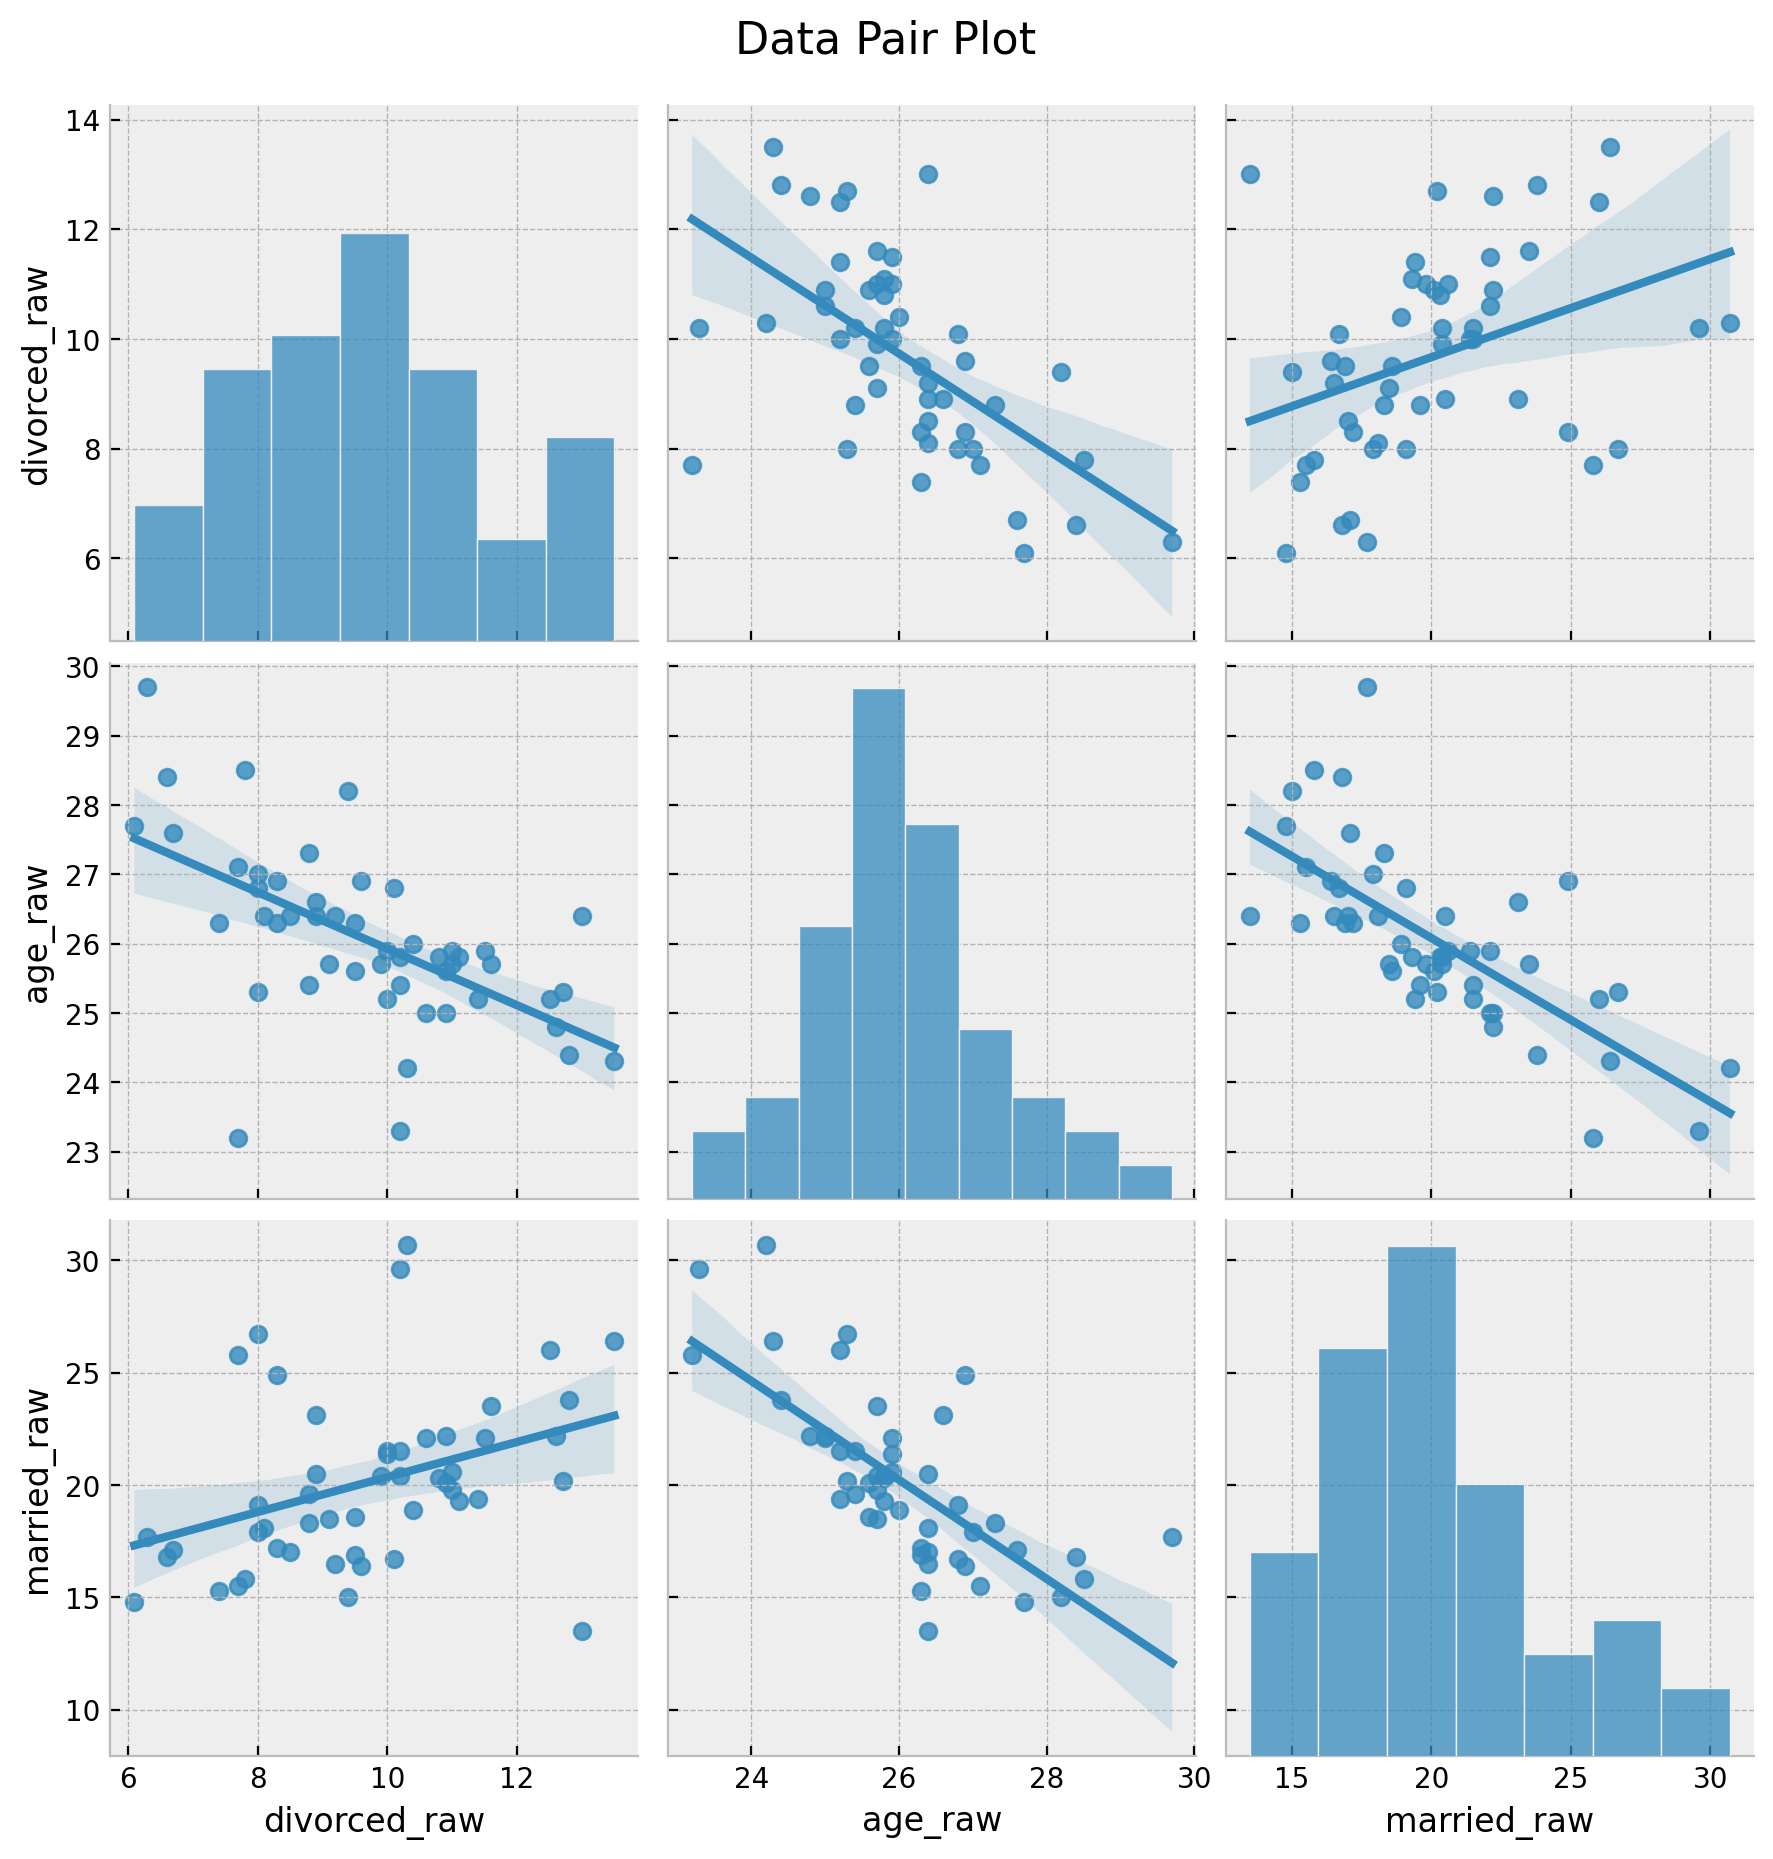

In [72]:
g = sns.pairplot(
    data=df,
    vars=["divorced_raw", "age_raw", "married_raw"],
    kind="reg",
    height=3,
    aspect=1,
)
g.fig.suptitle("Data Pair Plot", y=1.03, fontsize=16)

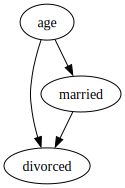

In [73]:
edges = [
    ("age", "divorced"),
    ("married", "divorced"),
    ("age", "married"),
]

g = gr.Digraph()

g.edges(edges)

g


In [74]:
def model(
    age: ArrayImpl, married: ArrayImpl, divorced: ArrayImpl | None = None
) -> None:
    # priors
    alpha = numpyro.sample(name="alpha", fn=dist.Normal(0, 0.2))
    beta_age = numpyro.sample(name="beta_age", fn=dist.Normal(0, 0.5))
    beta_married = numpyro.sample(name="beta_married", fn=dist.Normal(0, 0.5))
    sigma = numpyro.sample(name="sigma", fn=dist.Exponential(1))

    # parameterization
    mu = numpyro.deterministic(
        name="mu", value=alpha + beta_age * age + beta_married * married
    )

    n_obs = age.size
    # likelihood
    with numpyro.plate(name="data", size=n_obs):
        numpyro.sample(name="obs", fn=dist.Normal(mu, sigma), obs=divorced)


In [76]:
age = data["age"].to_numpy()
married = data["married"].to_numpy()
divorced = data["divorced"].to_numpy()


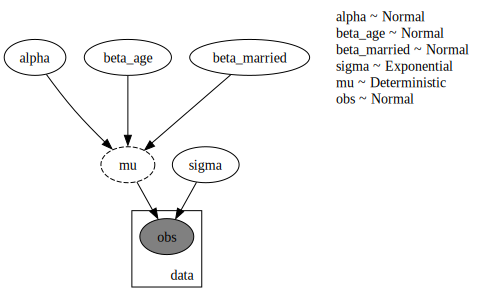

In [77]:
numpyro.render_model(
    model=model,
    model_args=(age, married, divorced),
    render_distributions=True,
    render_params=True,
)


In [81]:
# set sampler
nuts_kernel = NUTS(model=model, target_accept_prob=0.85)
mcmc = MCMC(sampler=nuts_kernel, num_samples=4_000, num_warmup=2_000, num_chains=4)
# run sampler
rng_key, rng_subkey = random.split(key=rng_key)
mcmc.run(rng_subkey, age, married, divorced)
# get posterior samples
posterior_samples = mcmc.get_samples()
# get posterior predictive samples
posterior_predictive = Predictive(model=model, posterior_samples=posterior_samples)
rng_key, rng_subkey = random.split(rng_key)
posterior_predictive_samples = posterior_predictive(rng_subkey, age, married)
# convert to arviz inference data object
idata = az.from_numpyro(
    posterior=mcmc, posterior_predictive=posterior_predictive_samples
)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [82]:
az.summary(data=idata, var_names=["~mu"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.000,0.104,-0.198,0.191,0.001,0.001,14501.0,11351.0,1.0
beta_age,-0.605,0.159,-0.903,-0.305,0.002,0.001,9763.0,9554.0,1.0
beta_married,-0.059,0.158,-0.364,0.227,0.002,0.001,9767.0,9999.0,1.0
sigma,0.835,0.089,0.682,1.008,0.001,0.001,14081.0,11523.0,1.0


Text(0.5, 0.98, 'Model Trace')

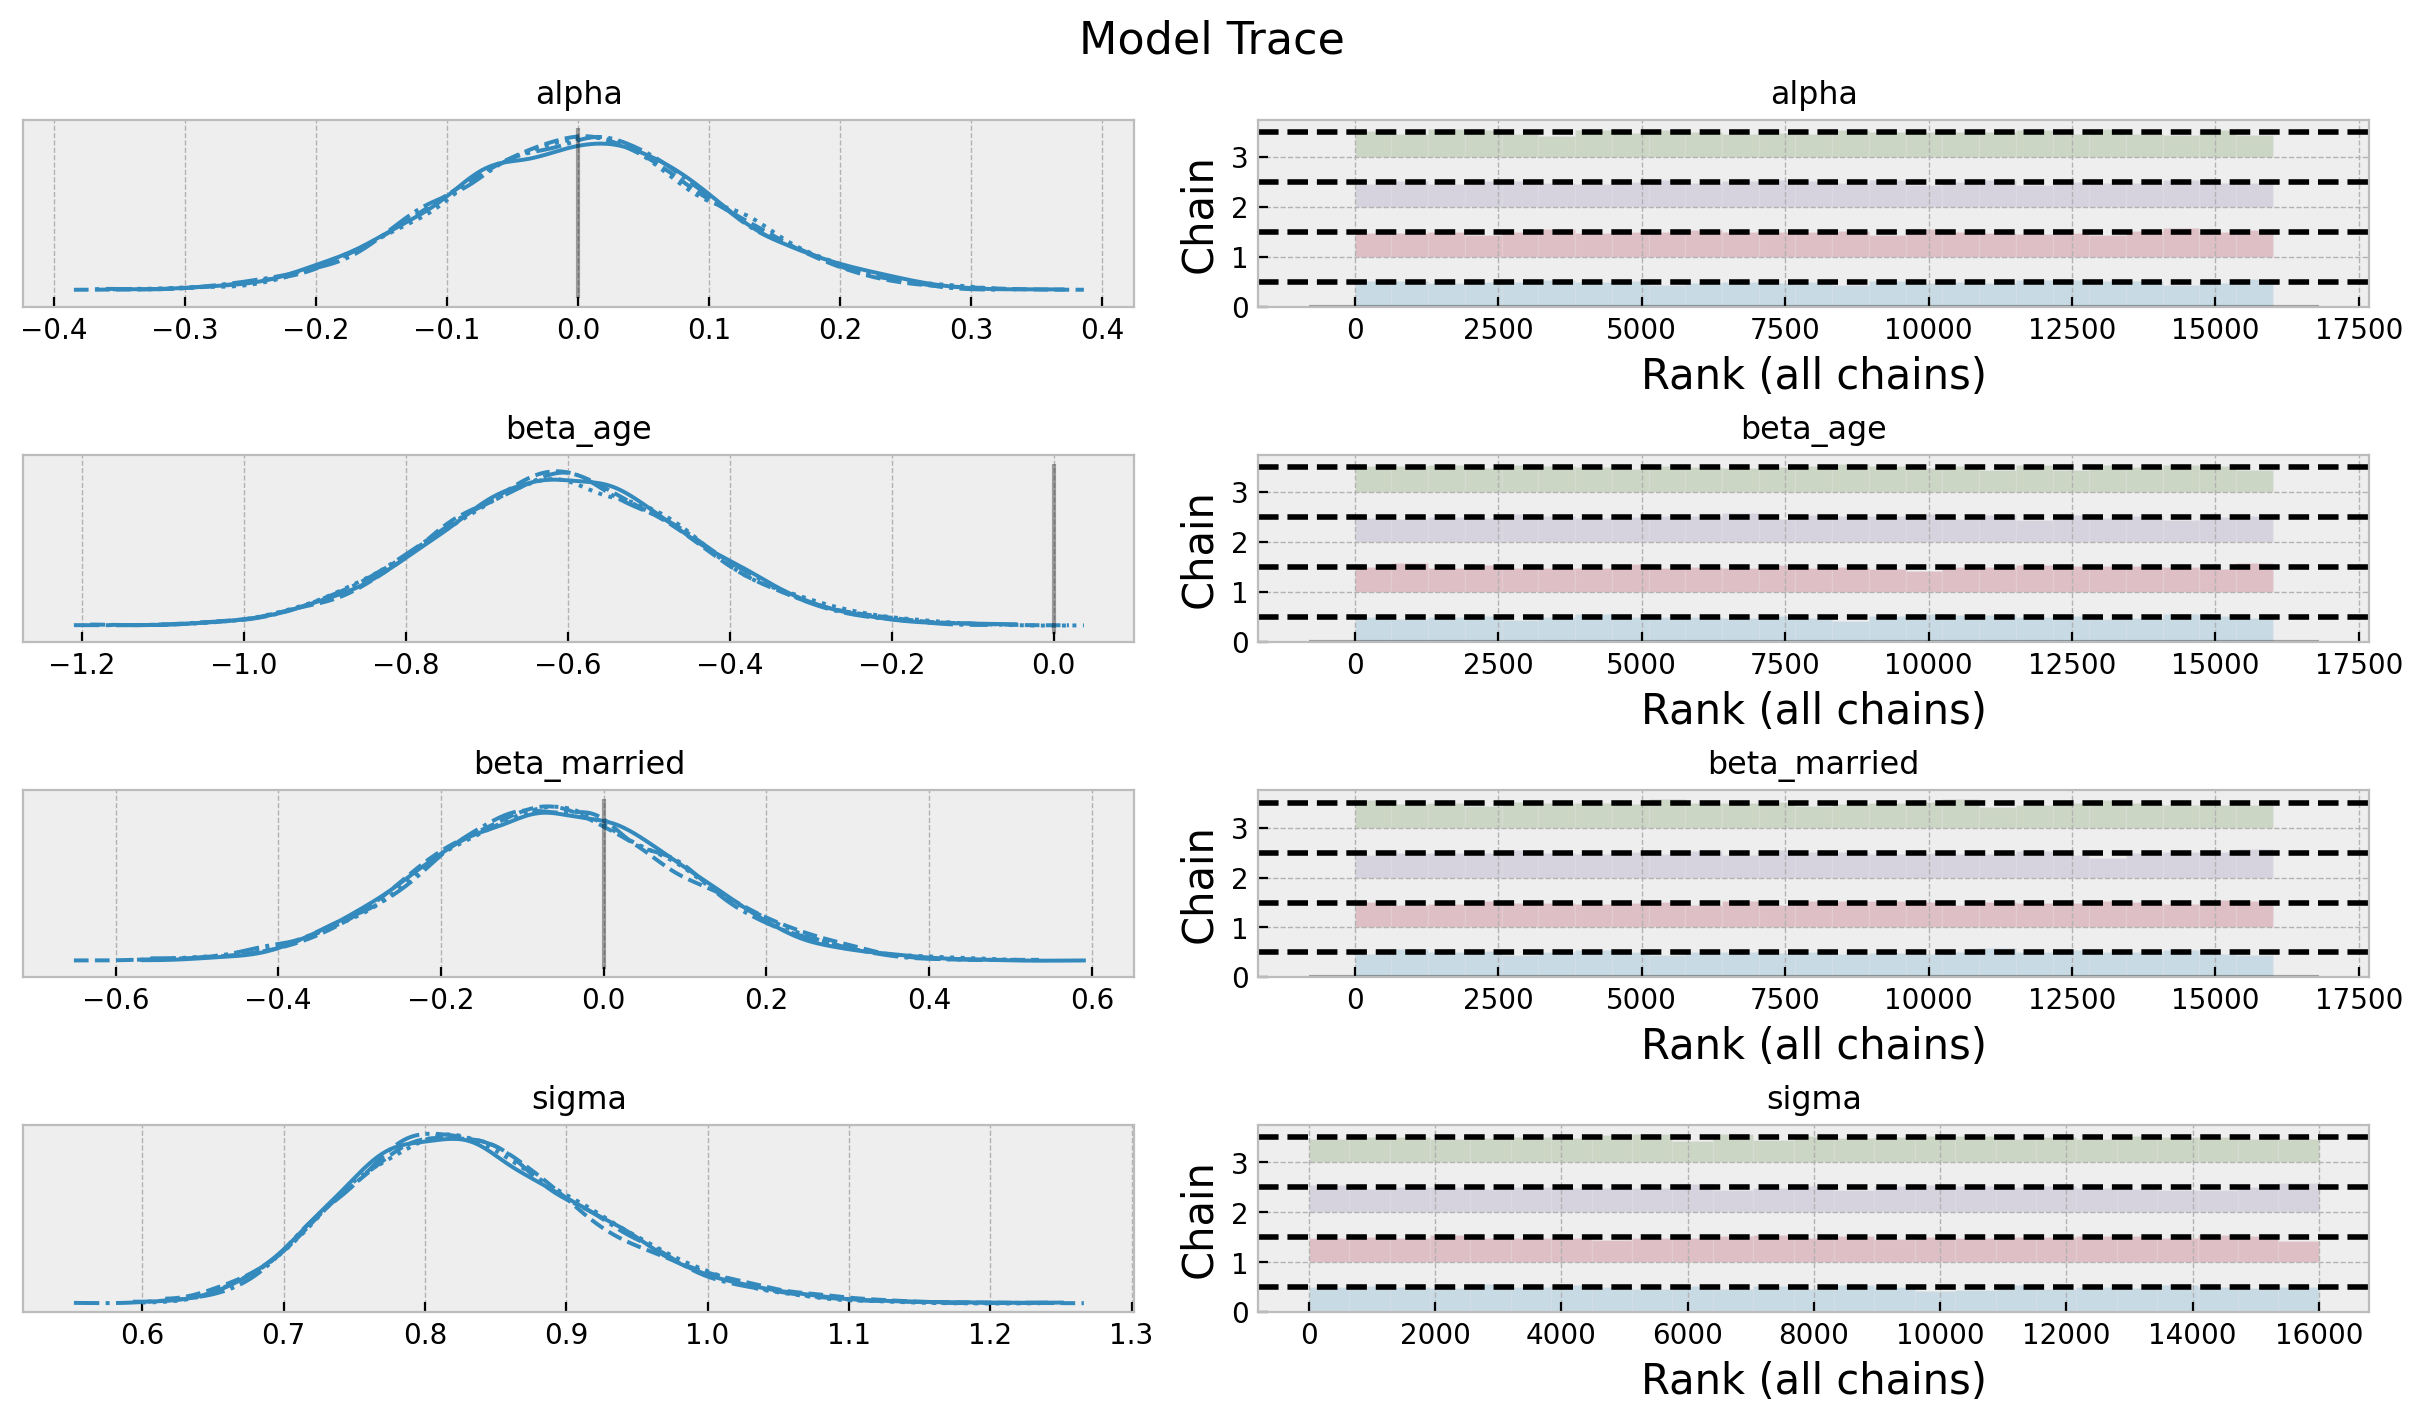

In [86]:
axes = az.plot_trace(
    data=idata,
    var_names=["~mu"],
    compact=True,
    kind="rank_bars",
    lines=[("alpha", {}, 0), ("beta_age", {}, 0), ("beta_married", {}, 0)],
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16)